## Packages and functions: correct labels, plot images, EDA

In [1]:
import pandas as pd
import numpy as np
import logging
import concurrent.futures
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import classification_report, balanced_accuracy_score, f1_score, confusion_matrix, balanced_accuracy_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import plotly.express as px
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, homogeneity_score, completeness_score, v_measure_score, silhouette_score
from sklearn.feature_selection import SelectFromModel
import threading
from sklearn.preprocessing import StandardScaler
from joblib import dump, load
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score
import warnings
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.manifold import TSNE
from sklearn.decomposition import KernelPCA

# Filter out specific warning types
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline
np.random.seed(0)
random_state = 42
print_lock = threading.Lock()

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

In [2]:
def rotateM(x, flip_vertical=False):
    if flip_vertical:
        return np.fliplr(x)
    else:
        return np.transpose(np.apply_along_axis(np.flip, 0, x))

def plot_mislabeled_images(indices, data, label, cmap='gray'):
    plt.figure(figsize=(20, 6))
    for idx, i in enumerate(indices):
        plt.subplot(2, 7, idx + 1)
        plt.imshow(rotateM(data.iloc[i, :].values.reshape(64, 64)), cmap=cmap)
        plt.title(label)
    plt.savefig(f'imgs/data_mislabeled.png')
    plt.show()

def plot_images(data, labels, label_names, key_='init', cmap='gray'):
    labels = labels.values.reshape(-1)
    num_rows = 18
    num_cols = 11
    plt.figure(figsize=(30, 30))
    for i in range(num_rows):
        for j in range(num_cols):
            idx = i * num_cols + j
            animal = label_names[labels[idx]]
            plt.subplot(18, 11, idx + 1)
            plt.imshow(rotateM(data.iloc[idx, :].values.reshape(64, 64)), cmap=cmap)
            plt.title(animal)
    plt.tight_layout()
    plt.savefig(f'imgs/{key_}/data.png')
    plt.show()

def correct_labels(data, true_dogs, true_cats):
    ''' 0 for cats and 1 for dogs'''
    for d in true_dogs:
        data.values[d] = 1
    for c in true_cats:
        data.values[c] = 0
    return data

ssc_mislabeled = [26, 54, 114, 117]
ssd_mislabeled = [8, 37, 112, 151, 176, 177]

In [3]:
def mean_animal(x, y):
    cat_indices = np.where(y == 0)[0]  
    dog_indices = np.where(y == 1)[0] 

    mean_cat = np.mean(x.iloc[cat_indices], axis=0)
    mean_dog = np.mean(x.iloc[dog_indices], axis=0)

    mean_cat_image = rotateM(mean_cat.values.reshape(64, 64))
    mean_dog_image = rotateM(mean_dog.values.reshape(64, 64))

    return mean_cat_image,  mean_dog_image

def plot_mean_images(x, y):
    ''' Mean Cat and Dog. '''
    mean_cat_image,  mean_dog_image = mean_animal(x, y)

    plt.figure(figsize=(12, 6))
    plt.subplot(2, 2, 1)
    plt.imshow(mean_cat_image, cmap='gray')
    plt.title('Mean Cat Image')
    plt.subplot(2, 2, 2)
    plt.imshow(mean_dog_image, cmap='gray')
    plt.title('Mean Dog Image')
    plt.savefig(f'imgs/mean_animal.png')
    plt.show()

In [4]:
def print_label_counts(y):
    num_cats = np.count_nonzero(y == 0)
    num_dogs = np.count_nonzero(y == 1)
    print("Number of cats:", num_cats)
    print("Number of dogs:", num_dogs)

## Models and functions: constants, objects, training and analysis

### Hyper-parameters

In [5]:
# Random Forest
n_estimators = [15, 50, 100, 150, 250]
max_depth = [None, 3, 5, 10]

# Logistic Regression
penalty = ['l2']
C = [0.01, 0.1, 1, 10]

# KNN
n_neighbors = [3, 5, 7, 10]
cluster_nums = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# SVM
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
C = [0.01, 0.1, 1, 10]

# MLP
hidden_layer_sizes = [(100,), (100, 50), (100, 75, 50), (200, ), (200, 100), (200, 150, 100)]

### Constants and objects

In [6]:
# Preprocessing
variance_threshold = VarianceThreshold()
scaler = StandardScaler()

# labels
label_names = ['Cat', 'Dog']

# Scoring
scoring = 'accuracy'

# Models meta data dictionary for grid search
model_map = { 
  'rf': {
    'model': RandomForestClassifier(random_state=random_state, n_jobs=-1),
    'params': {
      'rf__n_estimators': n_estimators,
      'rf__max_depth': max_depth,
    },
    'name': 'Random Forest'
  },
  
  'lr': {
    'model': LogisticRegression(random_state=random_state, n_jobs=-1, solver='lbfgs', max_iter=1000),
    'params': {
      'lr__penalty': penalty,
      'lr__C': C,
    },
    'name': 'Logistic Regression'
  },
  
  'knn': {
    'model': KNeighborsClassifier(n_jobs=-1),
    'params': {
      'knn__n_neighbors': n_neighbors,
    },
    'name': 'K-Nearest Neighbors'
  },
  
  'svm': {
    'model': SVC(random_state=random_state),
    'params': {
      'svm__kernel': kernel,
      'svm__C': C,
    },
    'name': 'Support Vector Machine'
  },
  
  'mlp': {
    'model': MLPClassifier(random_state=random_state, early_stopping=True),
    'params': {
      'mlp__hidden_layer_sizes': hidden_layer_sizes,
    }, 
    'name': 'Multi-Layer Perceptron'
  },
}

In [7]:
# constant and object for clustering
kernelPCA = KernelPCA(kernel='rbf', n_components=1000, random_state=random_state)
tsne = TSNE(n_components=2, random_state=random_state)

# key for the model used
cluster_models_keys = ['kmeans', 'dbscan', 'gmm']

### Functions: splits, grid search, classification report

In [8]:
def splits(X, Y, test_size=0.2, validation_set=False, validation_size=0.2):
    ''' Split into train and test. Validation size is the percentage of train data that will be validation data. '''
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state)
    
    if validation_set:
        X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=validation_size, random_state=random_state, stratify=Y_train)
        return X_train, X_val, X_test, Y_train, Y_val, Y_test
    
    return X_train, X_test, Y_train, Y_test

In [9]:
def run_grid_search(X_train, Y_train, model_key, model_info, scoring='accuracy', cv=3):
    best_params = {}
    best_cv_scores = {}
    best_models = {}
    
    model = model_info['model']
    params = model_info['params']
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        (model_key, model)
    ])

    # Perform grid search
    grid_search_res = GridSearchCV(pipeline, params, scoring=scoring, cv=cv, n_jobs=-1)
    grid_search_res.fit(X_train, np.ravel(Y_train))
    
    # Save best parameters and score
    best_params['model'] = grid_search_res.best_params_
    best_cv_scores['model'] = grid_search_res.best_score_
    best_models['model'] = grid_search_res.best_estimator_        
    
    return grid_search_res

In [10]:
def plot_confusion_matrix(Y_test, Y_pred, labels, model_name, key, flag_plot):
  # confusion matrix and display
  cm = confusion_matrix(Y_test, Y_pred)
  cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  
  # plot the confusion matrix
  cm_display.plot()
  plt.title(f'Confusion matrix for test data (model: {model_name})')
  plt.savefig(f'imgs/{key}/CM_{model_name}.png')
  if flag_plot:
    plt.show()
  
def show_classification_report(Y_test, Y_pred, model_name: str, key):
  print(f"Classification Report for test data (key: {key}, model: {model_name}) \n {classification_report(Y_test, Y_pred, target_names=label_names)}")

def plot_roc_curve(Y_test, Y_pred, model_name, key, flag_plot):
  fpr, tpr, _ = roc_curve(Y_test, Y_pred)
  roc_auc = auc(fpr, tpr)  # Calculate AUC score
  
  plt.plot(fpr, tpr, color='orange', label=f'ROC (AUC = {roc_auc:.2f})')  # Add AUC score to the label
  plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'ROC Curve for {model_name} (test data)')
  plt.legend()
  plt.savefig(f'imgs/{key}/ROC_{model_name}.png')
  if flag_plot:
    plt.show()

def plot_roc_curves(Y_test, model_predictions, model_names, key, flag_plot):
    plt.figure()
    
    for model_name, Y_pred in zip(model_names, model_predictions):
        fpr, tpr, _ = roc_curve(Y_test, Y_pred)
        roc_auc = auc(fpr, tpr)  # Calculate AUC score
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')  # Add AUC score to the label
    
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves for All Models (test data)')
    plt.legend(loc="lower right")
    plt.savefig(f'imgs/{key}/ROC_All_Models.png')
    if flag_plot:
        plt.show()

### Functions: part 1

In [11]:
def plot_feature_importance(results, X, Y, key, dim, n_best=500):
    feat_importance_lr = []
    feat_importance_rf = []
    feat_importance_anova = []
    
    for model_key, model_info in results.items():
        # random forest case
        if model_key == 'rf':
            model = model_info['grid_search_res'].best_estimator_
            feat_importance_rf.append(model.named_steps[model_key].feature_importances_)
        # logistic regression case
        if model_key == 'lr':
            model = model_info['grid_search_res'].best_estimator_
            feat_importance_lr.append(np.abs(model.named_steps[model_key].coef_))
            
    # compute feature importance with anova test
    anova = SelectKBest(score_func=f_classif, k='all')
    anova.fit(X, Y.values.ravel())
    
    # Ensure feature importance arrays are flattened and have the correct length
    feat_importance_lr = np.array(feat_importance_lr).flatten()
    feat_importance_rf = np.array(feat_importance_rf).flatten()
    feat_importance_anova = np.array(anova.scores_)
    
    # Function to get top n features and pad the rest with zeros
    def get_top_n_features(importance, n):
        top_indices = np.argsort(importance)[-n:]
        top_importance = np.zeros_like(importance)
        top_importance[top_indices] = importance[top_indices]
        return top_importance
    
    # Get the top n features for each method
    feat_importance_lr = get_top_n_features(feat_importance_lr, n_best)
    feat_importance_rf = get_top_n_features(feat_importance_rf, n_best)
    feat_importance_anova = get_top_n_features(feat_importance_anova, n_best)
        
    # Reshape a test image
    sample_image = rotateM(X.iloc[100, :].values.reshape(dim, dim))

    # Compute the coordinates for each pixel
    coordinates = [(i, j) for i in range(dim) for j in range(dim)]
    x, y = zip(*coordinates)
    
    # Function to plot feature importances
    def plot_importance(ax, image, importance, title):
        ax.imshow(image, cmap='gray')   
        scatter = ax.scatter(x, y, c=importance, cmap='hot', s=10)
        plt.colorbar(scatter, ax=ax)
        ax.set_title(title)

    # Create subplots
    _, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot feature importances
    plot_importance(axes[0], sample_image, feat_importance_rf, 'Random Forest Feature Importance')
    plot_importance(axes[1], sample_image, feat_importance_lr, 'Logistic Regression Feature Importance')
    plot_importance(axes[2], sample_image, feat_importance_anova, 'ANOVA Feature Importance')

    plt.tight_layout()
    plt.savefig(f'imgs/{key}/Feature_importance.png')
    plt.show()

#### Clustering

In [36]:
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import make_pipeline


def bench_clustering(estimator, name, data, labels, preprocessing_pipeline=make_pipeline(scaler), model_key='kmeans'):
    estimator = make_pipeline(preprocessing_pipeline, estimator).fit(data)
    
    pred_labels = estimator[-1].predict(data) if model_key == 'gmm' else estimator[-1].labels_
    result = {
        "name": name,
        "homogeneity": metrics.homogeneity_score(labels, pred_labels),
        "completeness": metrics.completeness_score(labels, pred_labels),
        "v measure": metrics.v_measure_score(labels, pred_labels),
        "ARI": metrics.adjusted_rand_score(labels, pred_labels),
        "AMI": metrics.adjusted_mutual_info_score(labels, pred_labels),
        "silhouette": metrics.silhouette_score(data, pred_labels)
    }
    
    if model_key == 'kmeans':
        result['n clusters'] = estimator[-1].n_clusters
        result['inertia'] = estimator[-1].inertia_
        
    if model_key == 'dbscan':
        result['eps'] = estimator[-1].eps
        result['min_samples'] = estimator[-1].min_samples
        
    if model_key == 'gmm':
        result['n clusters'] = estimator[-1].n_components
        result['bic'] = estimator[-1].bic(data)
        result['aic'] = estimator[-1].aic(data)
        
    return result, estimator[-1]

def plot_class_distribution(X, Y):
    # Perform PCA on features
    X_proj = PCA(n_components=2).fit_transform(scaler.fit_transform(X))

    # Plot actual classes
    plt.figure(figsize=(12, 8))
    for i in np.unique(Y):
        plt.scatter(X_proj[Y == i, 0], X_proj[Y == i, 1], label=f"Class {i}", s=50)
    plt.title("Class distribution", fontsize=18)
    plt.xlabel("PC1", fontsize=18)
    plt.ylabel("PC2", fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend(fontsize=18)
    plt.tight_layout()
    plt.show()

def plot_within_scatter_per_k(within_scatter, cluster_numbers, model_key='kmeans'):    
    # Create a DataFrame for plotting within-cluster scatter
    data_scatter_plot = pd.DataFrame(within_scatter).T
    data_scatter_plot.columns = cluster_numbers
    data_scatter_plot = data_scatter_plot.melt(var_name='K', value_name='value')
    data_scatter_plot['rep'] = data_scatter_plot.index

    # Plot within-cluster scatter
    plt.figure(figsize=(12, 8))
    sns.stripplot(x='K', y='value', data=data_scatter_plot, jitter=True, size=5, alpha=0.5)
    plt.title("Within-Cluster Scatter", fontsize=18)
    plt.xlabel("Number of Clusters (K)", fontsize=18)
    plt.ylabel("W(C)" if model_key == 'kmeans' else 'bic', fontsize=18)
    plt.xticks(np.array(cluster_numbers, dtype=float), fontsize=18)
    plt.yticks(fontsize=18)

    plt.tight_layout()
    plt.show()

def plot_scores_per_k(results, cluster_numbers, model_key='kmeans'):
    plt.figure(figsize=(12, 8))
    sns.color_palette("colorblind")
    
    plt.plot(np.array(cluster_numbers), [result['homogeneity'] for result in results], label='Homogeneity', marker='o')
    plt.plot(np.array(cluster_numbers), [result['completeness'] for result in results], label='Completeness', marker='o')
    plt.plot(np.array(cluster_numbers), [result['v measure'] for result in results], label='V score', marker='o')
    plt.plot(np.array(cluster_numbers), [result['ARI'] for result in results], label='Adjusted Rand Index Score', marker='o')
    plt.plot(np.array(cluster_numbers), [result['silhouette'] for result in results], label='Silhouette score', marker='o')
    plt.plot(np.array(cluster_numbers), [result['AMI'] for result in results], label='Adjusted Mutual Info', marker='o')
    if model_key == 'gmm':
        plt.plot(np.array(cluster_numbers), [result['bic'] for result in results], label='BIC', marker='o')
        plt.plot(np.array(cluster_numbers), [result['aic'] for result in results], label='AIC', marker='o')
    
    plt.xlabel('Number of clusters' if model_key == 'kmeans' else 'Epsilon' if model_key == 'dbscan' else 'Number of components')
    plt.ylabel('Score')
    plt.title('Clustering Scores')
    plt.legend()
    plt.show()

def plot_decision_boundary(X, Y, n_clusters, estimator):
    X_proj = tsne.fit_transform(X)
    
    # Step size of the mesh
    h = 0.02
    
    # Plot the decision boundary. For that, we will assign a color to each point in the mesh [x_min, x_max] x [y_min, y_max].
    x_min, x_max = X_proj[:, 0].min() - 1, X_proj[:, 0].max() + 1
    y_min, y_max = X_proj[:, 1].min() - 1, X_proj[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Obtain labels for each point in mesh. Use last trained model.
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()].astype(np.float64))
    
    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')
    
    # Scatter plot of the points with true labels as colors
    scatter = plt.scatter(X_proj[:, 0], X_proj[:, 1], c=Y, cmap='viridis', marker='o', alpha=0.6)
    
    # Plot the centroids as a white cross
    centroids = estimator.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    
    plt.title(f'KMeans clustering with {n_clusters} clusters\n')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.colorbar(scatter, label='True Labels')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

def run_kmeans(X, Y, cluster_numbers=cluster_nums, n_times=10, preprocessing_pipeline=make_pipeline(scaler)):
    results = []
    within_scatter = []

    plot_class_distribution(X, Y)
    
    for K in cluster_numbers:
        within_scatter_K = []
        mid_results = []
        for _ in range(n_times):            
            result, _ = bench_clustering(
                estimator=KMeans(n_clusters=K, random_state=random_state), 
                name=f"k-means ({K} clusters)", 
                data=X, 
                labels=Y,
                preprocessing_pipeline=preprocessing_pipeline
            )
            mid_results.append(result)
            within_scatter_K.append(result['inertia'])
            
        within_scatter.append(within_scatter_K)
        
        results.append({
            'n clusters': K,
            'homogeneity': np.mean([result['homogeneity'] for result in mid_results]),
            'completeness': np.mean([result['completeness'] for result in mid_results]),
            'v measure': np.mean([result['v measure'] for result in mid_results]),
            'ARI': np.mean([result['ARI'] for result in mid_results]),
            'AMI': np.mean([result['AMI'] for result in mid_results]),
            'silhouette': np.mean([result['silhouette'] for result in mid_results])
        })    
        # plot_decision_boundary(X, Y, K, kmeans)
        
    plot_within_scatter_per_k(within_scatter, cluster_numbers)
    plot_scores_per_k(results, cluster_numbers)
    
    return pd.DataFrame(results)

def run_dbscan(X, Y, eps_values, min_samples_values, preprocessing_pipeline=make_pipeline(scaler)):
    results = []
    
    for eps in eps_values:
        for min_samples in min_samples_values:
            result, _ = bench_clustering(
                estimator=DBSCAN(eps=eps, min_samples=min_samples), 
                name=f"DBSCAN (eps={eps}, min_samples={min_samples})", 
                data=X, 
                labels=Y,
                preprocessing_pipeline=preprocessing_pipeline,
                model_key='dbscan'
            )
            results.append(result)
    
    return pd.DataFrame(results)

# FIXME: It's a model-bsaed clustering algorithm, so it's not possible to use the same pipeline as the other clustering algorithms
# also we may need to split the data in this case
def run_gmm(X, Y, cluster_numbers=cluster_nums, n_times=10, preprocessing_pipeline=make_pipeline(scaler)):
    results = []
    within_scatter = []

    plot_class_distribution(X, Y)
    
    for K in cluster_numbers:
        within_scatter_K = []
        mid_results = []
        for _ in range(n_times):
            # In the context of Gaussian Mixture Models (GMM), 
            # the n_components parameter represents the number of 
            # Gaussian distributions that make up the mixture model. 
            result, _ = bench_clustering(
                estimator=GaussianMixture(n_components=K, random_state=random_state), 
                name=f"GMM ({K} clusters)", 
                data=X, 
                labels=Y,
                preprocessing_pipeline=preprocessing_pipeline,
                model_key='gmm'
            )
            mid_results.append(result)
            within_scatter_K.append(result['bic'])
            
        within_scatter.append(within_scatter_K)
        
        results.append({
            'n clusters': K,
            'homogeneity': np.mean([result['homogeneity'] for result in mid_results]),
            'completeness': np.mean([result['completeness'] for result in mid_results]),
            'v measure': np.mean([result['v measure'] for result in mid_results]),
            'ARI': np.mean([result['ARI'] for result in mid_results]),
            'AMI': np.mean([result['AMI'] for result in mid_results]),
            'silhouette': np.mean([result['silhouette'] for result in mid_results]),
            'bic': np.mean([result['bic'] for result in mid_results]),
            'aic': np.mean([result['aic'] for result in mid_results])
        })    
        
    plot_within_scatter_per_k(within_scatter, cluster_numbers)
    plot_scores_per_k(results, cluster_numbers)
    
    return pd.DataFrame(results)

# TODO: Implement Agglomerative Clustering pipeline
def run_agglomerative():
    pass

In [13]:
def bench_clustering2(estimator, name, data, labels, preprocessing_pipeline=make_pipeline(scaler)):
    estimator = make_pipeline(preprocessing_pipeline, estimator).fit(data)
    
    result = {
        "name": name,
        'n clusters': estimator[-1].n_clusters,
        "inertia": estimator[-1].inertia_,
        "homogeneity": metrics.homogeneity_score(labels, estimator[-1].labels_),
        "completeness": metrics.completeness_score(labels, estimator[-1].labels_),
        "v measure": metrics.v_measure_score(labels, estimator[-1].labels_),
        "ARI": metrics.adjusted_rand_score(labels, estimator[-1].labels_),
        "AMI": metrics.adjusted_mutual_info_score(labels, estimator[-1].labels_),
        "silhouette": metrics.silhouette_score(data, estimator[-1].labels_)
    }
    return result, estimator[-1], estimator[-1].labels_

def generate_contingency_table(labels, cluster_labels):
    return pd.crosstab(labels, cluster_labels)


def run_clustering2(X, Y, cluster_numbers=cluster_nums, n_times=20, preprocessing_pipeline=make_pipeline(scaler)):
    results = []
    contingency_tables = []

    for K in cluster_numbers:
        within_scatter_K = []
        mid_results = []
        for _ in range(n_times):            
            result, kmeans, cluster_labels = bench_clustering2(
                estimator=KMeans(n_clusters=K, random_state=random_state), 
                name=f"k-means ({K} clusters)", 
                data=X, 
                labels=Y,
                preprocessing_pipeline=preprocessing_pipeline
            )
            mid_results.append(result)
            within_scatter_K.append(result['inertia'])
            
        results.append({
            'n clusters': K,
            'homogeneity': np.mean([result['homogeneity'] for result in mid_results]),
            'completeness': np.mean([result['completeness'] for result in mid_results]),
            'v measure': np.mean([result['v measure'] for result in mid_results]),
            'ARI': np.mean([result['ARI'] for result in mid_results]),
            'AMI': np.mean([result['AMI'] for result in mid_results]),
            'silhouette': np.mean([result['silhouette'] for result in mid_results])
        })    

        contingency_table = generate_contingency_table(Y, cluster_labels)
        contingency_table.columns = [f'Cluster_{K}_{col}' for col in contingency_table.columns]
        contingency_tables.append(contingency_table)

        print(contingency_table)

        combined_contingency_table = pd.concat(contingency_tables, axis=1)
    
    return pd.DataFrame(results), combined_contingency_table

In [14]:
results2, contingency_table = run_clustering2(X_cats_dogs, np.ravel(Y_cats_dogs), cluster_numbers=cluster_nums)

NameError: name 'X_cats_dogs' is not defined

In [ ]:
contingency_table

,Cluster_2_0,Cluster_2_1,Cluster_3_0,Cluster_3_1,Cluster_3_2,Cluster_4_0,Cluster_4_1,Cluster_4_2,Cluster_4_3,Cluster_5_0,...,Cluster_10_0,Cluster_10_1,Cluster_10_2,Cluster_10_3,Cluster_10_4,Cluster_10_5,Cluster_10_6,Cluster_10_7,Cluster_10_8,Cluster_10_9
row_0,,,,,,,,,,,,,,,,,,,,,
0,52,47,20,23,56,14,25,21,39,15,...,15,0,5,2,9,11,13,0,18,26
1,49,50,13,39,47,7,22,55,15,5,...,21,3,28,0,2,15,4,15,9,2


### Functions: part 2

In [ ]:
def plot_sample_image_with_grid(data, image_index=1):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(rotateM(data.iloc[image_index, :].values.reshape(64, 64)), cmap='gray')
    plt.title('Random Image')
    plt.subplot(1, 2, 2)
    plt.imshow(rotateM(data.iloc[image_index, :].values.reshape(64, 64)), cmap='gray')
    plt.title('Random Image with Grid')
    for i in range(1, 4):
        plt.axhline(i * 16, color='r', linestyle='--')
        plt.axvline(i * 16, color='r', linestyle='--')
        for row in range(4):
            for col in range(4):
                plt.text(col * 16 + 3, row * 16 + 3, str(row * 4 + col), color='r')
    plt.show()

def plot_mean_images_with_grid(x, y):
    ''' Mean Cat and Dog. '''
    mean_cat_image,  mean_dog_image = mean_animal(x, y)

    plt.figure(figsize=(12, 6))
    plt.subplot(2, 2, 1)
    plt.imshow(mean_cat_image, cmap='gray')
    plt.title('Mean Cat Image')
    plt.subplot(2, 2, 2)
    plt.imshow(mean_dog_image, cmap='gray')
    plt.title('Mean Dog Image')
    plt.subplot(2, 2, 3)
    plt.imshow(mean_cat_image, cmap='gray')
    plt.title('Mean Cat Image with Grid')
    for i in range(1, 4):
        plt.axhline(i * 16, color='r', linestyle='--')
        plt.axvline(i * 16, color='r', linestyle='--')
        for row in range(4):
            for col in range(4):
                plt.text(col * 16 + 3, row * 16 + 3, str(row * 4 + col), color='r')
    plt.subplot(2, 2, 4)
    plt.imshow(mean_dog_image, cmap='gray')
    plt.title('Mean Dog Image with Grid')
    for i in range(1, 4):
        plt.axhline(i * 16, color='r', linestyle='--')
        plt.axvline(i * 16, color='r', linestyle='--')
        for row in range(4):
            for col in range(4):
                plt.text(col * 16 + 3, row * 16 + 3, str(row * 4 + col), color='r')
    plt.savefig(f'imgs/mean_animal.png')
    plt.show()

def blocks_datasets(dataset):
    """ 16 datasets, each representing a block. """
    blocks = []  
    for row in range(4): 
        for col in range(4):  
            # pixel/feature indices corresponding to the block
            block_indices = [] 
            for i in range(64):  
                for j in range(64): 
                    # add the pixel belongs to the current block
                    if (i // 16 == row) and (j // 16 == col):
                        # calculate index of the pixel
                        block_indices.append(i * 64 + j)
            blocks.append(dataset[:, block_indices])

            # plot the block against the original image
            plt.figure(figsize=(10, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(rotateM(dataset[0].reshape(64, 64)), cmap='gray')
            plt.title('Original Image')
            plt.subplot(1, 2, 2)
            plt.imshow(rotateM(blocks[-1][0].reshape(16, 16)), cmap='gray')
            plt.title(f'Block {row * 4 + col}')
            plt.show()
    return blocks

# plot image and block 
def plot_blocks(dataset, block_dataset):
    plt.figure(figsize=(10, 5))
    plt.subplot(2, 3, 1)
    plt.imshow(rotateM(dataset.iloc[3, :].values.reshape(64, 64)), cmap='gray')
    # define picture
    img = 3
    c = 2
    for i in [1, 2, 3, 4, 5, 6]:
        plt.subplot(2, 3, c)
        plt.imshow(rotateM(block_dataset[i][img].reshape(16, 16)), cmap='gray')
        c = c + 1
    plt.show()

def flip_half_images_upside_down(X, Y):
    ''' Flip half of the images (reorder columns for half of the dataset).'''
    # cats and dogs random selection
    cat_indices = np.where(Y == 0)[0]
    dog_indices = np.where(Y == 1)[0]
    np.random.shuffle(cat_indices)
    np.random.shuffle(dog_indices)
    # 44 cats and 45 dogs
    cat_indices_to_flip = cat_indices[:44]
    dog_indices_to_flip = dog_indices[:45]

    X_flipped = X.copy()
    # flatten result of flipped images
    for idx in cat_indices_to_flip:
        X_flipped.iloc[idx] = rotateM(X_flipped.iloc[idx].values.reshape(64, 64), flip_vertical=True).flatten()

    for idx in dog_indices_to_flip:
        X_flipped.iloc[idx] = rotateM(X_flipped.iloc[idx].values.reshape(64, 64), flip_vertical=True).flatten()
        
    return X_flipped
    

## Main processes

In [ ]:
def process_model(model_key, model_info, X_train, X_test, Y_train, Y_test, key, scoring='accuracy'):
    ''' Best parameters for a given algorithm. '''
    # grid search to get best model/parameters for given algorithm
    grid_search_res = run_grid_search(X_train, Y_train, model_key, model_info)
    Y_test_pred = grid_search_res.predict(X_test)
    
    # metrics on the test data
    test_accuracy = accuracy_score(Y_test, Y_test_pred)
    test_f1_score = f1_score(Y_test, Y_test_pred, average='macro')
    test_roc_auc_score = roc_auc_score(Y_test, Y_test_pred)
        
    # prepare log messages
    log_messages = [
        f'Experiment: {key}\n'
        f"Best parameters found for {model_info['name']}: {grid_search_res.best_params_}",
        f"Best CV {scoring} score: {grid_search_res.best_score_}",
        f'Model: {model_info["name"]}, test accuracy score: {test_accuracy}, test f1 Score: {test_f1_score}',
    ]

    # return info
    return {
        'model_key': model_key,
        'model_name': model_info["name"], 
        'grid_search_res': grid_search_res, 
        'test_accuracy': test_accuracy, 
        'test_f1_score': test_f1_score,
        'test_roc_auc_score': test_roc_auc_score,
        'Y_test_pred': Y_test_pred,
        'log_messages': log_messages,
    }



def show_results_summary(results, key='init'):
    # Print results summary in a tabular format (using pandas DataFrame)
    results_summary = []
    for _, result in results.items():
        results_summary.append({
            'Model': result['model_name'],
            'CV accuracy': result['grid_search_res'].best_score_,
            'Test Accuracy': result['test_accuracy'],
            'Test f1 score': result['test_f1_score'],
            'Test ROC AUC score': result['test_roc_auc_score'],
        })
        
    results_df = pd.DataFrame(results_summary)
    display(results_df)

In [ ]:
def main_parallel(model_map, X, Y, key, flag_plot=True):
    results = {} # keys are model keys and values are results dictionaries
    model_predictions = []
    model_names = []
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        # split dataset
        X_train, X_test, Y_train, Y_test = splits(X, Y)
        
        futures = {}
        for model_key, model_info in model_map.items():
            future = executor.submit(process_model, model_key, model_info, X_train, X_test, Y_train, Y_test, key)
            futures[future] = model_key
        
        for future in concurrent.futures.as_completed(futures):
            model_key = futures[future]
            result = future.result()
            results[model_key] = result
                
        # print results summary
        if key == 'init':
            with print_lock:
                print('\n\n**************************************************')
                print('**RESULTS SUMMARY**\n')
                show_results_summary(results)
                print('**************************************************\n\n')
                
        # print results for each model
        for _, result in results.items():
            # log results
            with print_lock:
                
                print('--------------------------------------------------')
                for message in result['log_messages']:
                    print(message)
                plot_confusion_matrix(Y_test, result['Y_test_pred'], label_names, result['model_name'], key, flag_plot)
                plot_roc_curve(Y_test, result['Y_test_pred'], result['model_name'], key, flag_plot)
                show_classification_report(Y_test, result['Y_test_pred'], result['model_name'], key)
                print('--------------------------------------------------\n\n')
                model_predictions.append(result['Y_test_pred'])
                model_names.append(result['model_name'])
    
    # All ROC curves on the same plot
    plot_roc_curves(Y_test, model_predictions, model_names, key, flag_plot)
    
    return results

In [ ]:
def get_results_blocks(model_map, X, Y, key, flag=False, flag_plot=True):
    X_cats_dogs_blocks = blocks_datasets(X.values)
    if flag:
        plot_blocks(X, X_cats_dogs_blocks)
    
    results_blocks = []

    for index, X_block in enumerate(X_cats_dogs_blocks):
        results = {}
        results['block'] = X_block
        results['results'] = main_parallel(model_map, X_block, Y, f"block_{index}", flag_plot)  
        results_blocks.append(results)

    return results_blocks

## Read data and work on it

In [16]:
# read cats and dogs data
X_cats_dogs = pd.read_csv('../data/CATSnDOGS.csv')
Y_cats_dogs = pd.read_csv('../data/CATSnDOGSlabels.csv')

# X_cats_dogs_flipped = pd.DataFrame(flip_half_images_upside_down(X_cats_dogs, Y_cats_dogs))
Y_cats_dogs = correct_labels(Y_cats_dogs, true_dogs = [26, 54, 114, 117], true_cats = [8, 37, 112, 151, 176, 177])

#plot_mislabeled_images(ssc_mislabeled, X_cats_dogs, label="cat") 
#plot_images(X_cats_dogs, Y_cats_dogs, {0: "cat", 1: "dog"}, key_='init')
#plot_mean_images(X_cats_dogs, Y_cats_dogs)
#print_label_counts(Y_cats_dogs)

### 1.a Comparison of classifiers

In [ ]:
# results = main_parallel(model_map, X_cats_dogs, Y_cats_dogs, key='init', flag_plot=True)

### 1.b Feature importance methods

In [ ]:
# plot_feature_importance(results, X_cats_dogs, Y_cats_dogs, key='init', dim=64)

### 1.c Clustering

#### Just scaling

In [ ]:
results_scaling = run_kmeans(X_cats_dogs, np.ravel(Y_cats_dogs), cluster_numbers=cluster_nums)
results_scaling

#### kernelPCA (rbf)

In [ ]:
# Define the range of number of components to try
n_components_range = [10, 20, 30, 50, 100]

# Perform grid search
for n_components in n_components_range:
    kernelPCA.set_params(kernel='rbf', n_components=n_components)
    print(f"Number of components: {n_components}")
    results_rbf_pca = run_kmeans(
      X_cats_dogs, 
      np.ravel(Y_cats_dogs), 
      cluster_numbers=cluster_nums,
      preprocessing_pipeline=make_pipeline(scaler, kernelPCA)
    )

#### using DBSCAN

In [ ]:
# FIXME: all the labels are -1
results_dbscan = run_dbscan(X_cats_dogs, np.ravel(Y_cats_dogs), eps_values=[0.1, 0.5, 1, 2], min_samples_values=[10, 20, 50])
results_dbscan

#### Gaussian Mixture Model

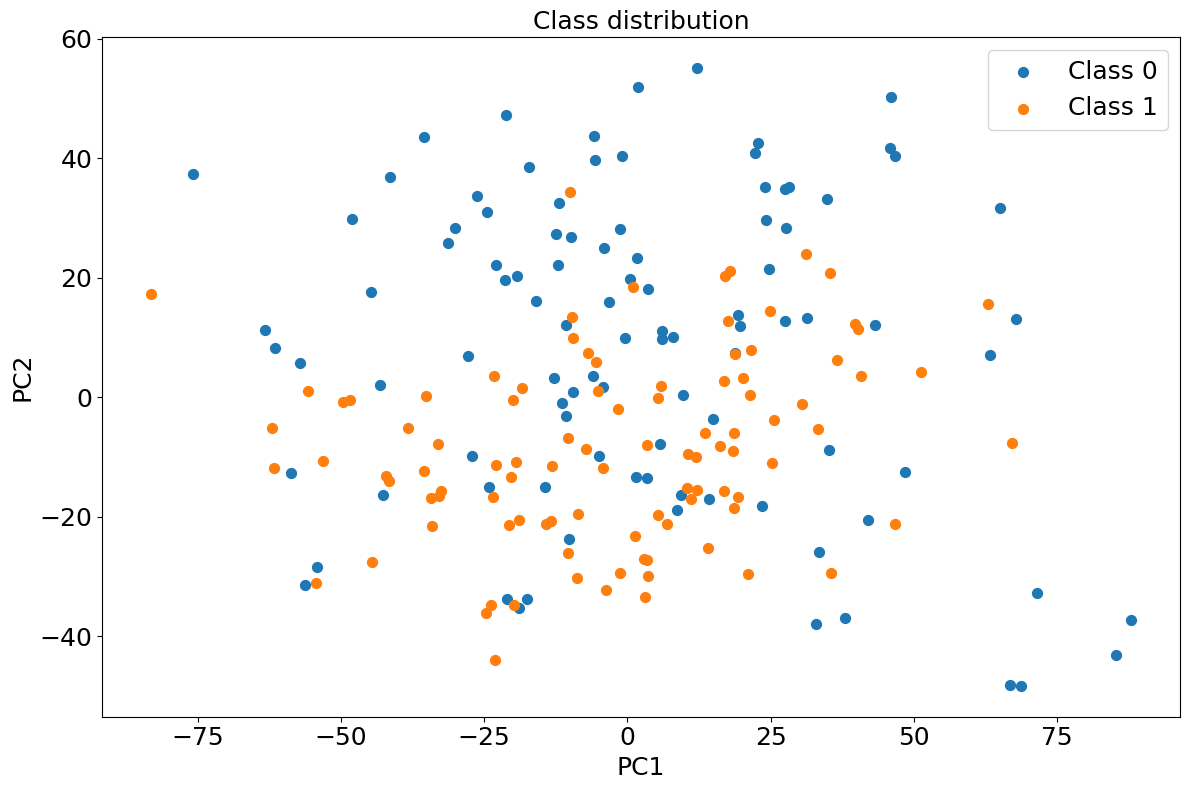

/home/lucamodica/mambaforge/envs/statistical/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GaussianMixture was fitted without feature names
  warnings.warn(
/home/lucamodica/mambaforge/envs/statistical/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GaussianMixture was fitted without feature names
  warnings.warn(
/home/lucamodica/mambaforge/envs/statistical/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GaussianMixture was fitted without feature names
  warnings.warn(
/home/lucamodica/mambaforge/envs/statistical/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GaussianMixture was fitted without feature names
  warnings.warn(
/home/lucamodica/mambaforge/envs/statistical/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but GaussianMixture was fitted without feature names
  warnings.warn(
/home

KeyboardInterrupt: 

In [37]:
# results_gmm = run_gmm(X_cats_dogs, np.ravel(Y_cats_dogs), cluster_numbers=cluster_nums)
# results_gmm

### 2.b Results for blocks

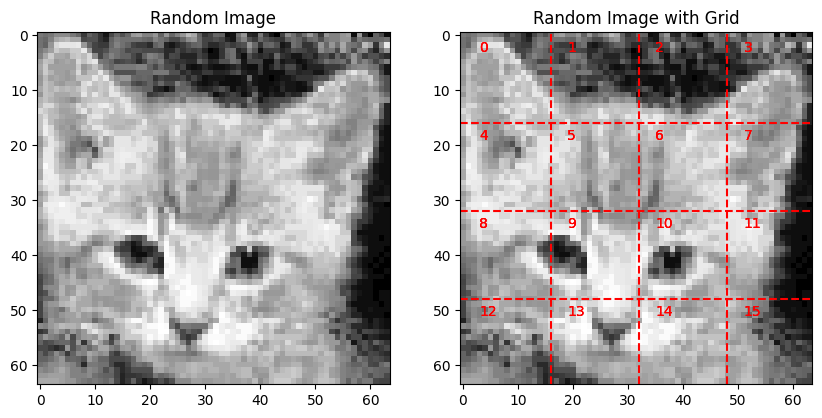

In [ ]:
plot_sample_image_with_grid(X_cats_dogs, image_index=0)

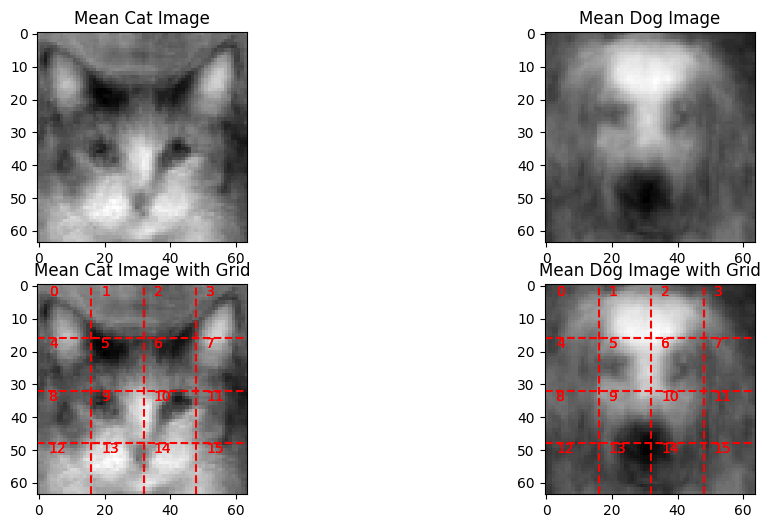

In [ ]:
plot_mean_images_with_grid(X_cats_dogs, Y_cats_dogs)

### 2.c Results for flipped images

In [ ]:
# results_flipped = main_parallel(model_map, X_cats_dogs_flipped, Y_cats_dogs, key='flipped')
# plot_feature_importance(results_flipped, X_cats_dogs, Y_cats_dogs, key='flipped', dim=64)
# plot_images(data=X_cats_dogs_flipped, labels=Y_cats_dogs, label_names={0: "cat", 1: "dog"}, key_='flipped')

In [ ]:
# results_flipped = main_parallel(model_map, X_cats_dogs_flipped, Y_cats_dogs, key='flipped')
# plot_feature_importance(results_flipped, X_cats_dogs, Y_cats_dogs, key='flipped', dim=64)
# plot_images(data=X_cats_dogs_flipped, labels=Y_cats_dogs, label_names={0: "cat", 1: "dog"}, key_='flipped')

In [ ]:
# results_flipped = main_parallel(model_map, X_cats_dogs_flipped, Y_cats_dogs, key='flipped')
# plot_feature_importance(results_flipped, X_cats_dogs, Y_cats_dogs, key='flipped', dim=64)
# plot_images(data=X_cats_dogs_flipped, labels=Y_cats_dogs, label_names={0: "cat", 1: "dog"}, key_='flipped')